In [1]:
# %pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dtaset eeg sampling rate
data_portion = 1
save_model = False

df = pd.read_csv('features_raw.csv')
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


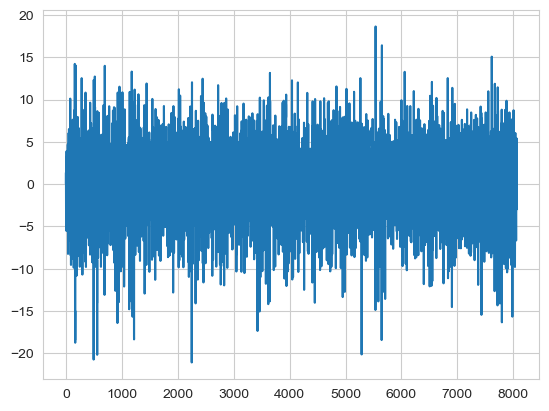

In [3]:
plt.plot(df['Fp1'])

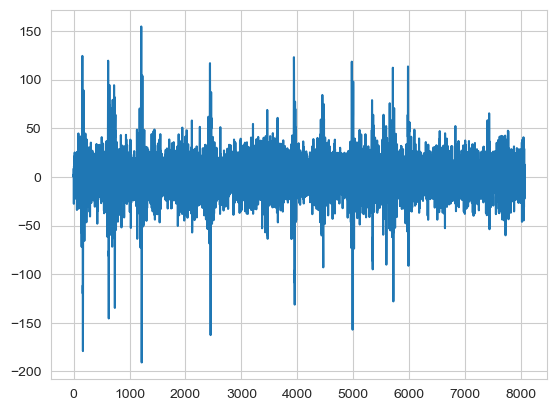

In [4]:
plt.plot(df['T8'])

In [5]:
class EEGDataset:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            """
            This code block iterates through each channel, splits the data into segments of size array_size, and converts these segments to NumPy arrays.
            It then adds these arrays to the isolated_channel list and adds isolated_channel to the channels list when it finishes processing a channel.
            Finally, it returns a NumPy array containing all the channel data.
            """
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        """
        If self.isolated_channels is False, this block will simply iterate through each channel
        and split the data into segments of size array_size, which are then converted to NumPy arrays and added to the dataset list.
        Finally, it returns a NumPy array containing all the data.
        """
        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [6]:
train_csv = 'features_raw.csv'
eegDataset = EEGDataset(train_csv, seconds, fs, data_portion, normalize=True)
train_dataset = eegDataset.get_data()

In [7]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
# This line of code creates an instance of the HBOS classifier and assigns it to the variable clf. HBOS (Histogram-based Outlier Score) is an algorithm for anomaly detection.
clf.fit(train_dataset)
print(train_dataset.shape)

(2016, 128)


In [8]:
# # Assuming train_dataset is a NumPy array of shape (2016, 128)
# num_features_to_plot = train_dataset.shape[1]  # We'll only plot the first 100 features
# num_plots_per_row = 4  # Adjust as needed
# num_rows = int(num_features_to_plot / num_plots_per_row) + (num_features_to_plot % num_plots_per_row > 0)
#
# plt.figure(figsize=(15, 3*num_rows))  # Adjusted figsize
#
# for i in range(num_features_to_plot):
#     plt.subplot(num_rows, num_plots_per_row, i+1)
#     plt.hist(train_dataset[:, i], bins=17, alpha=0.5, color='b', edgecolor='k')
#     plt.title(f'Feature {i+1}')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     print("No. " + str(i) + " has finished...")
#
# plt.tight_layout()
# plt.show()

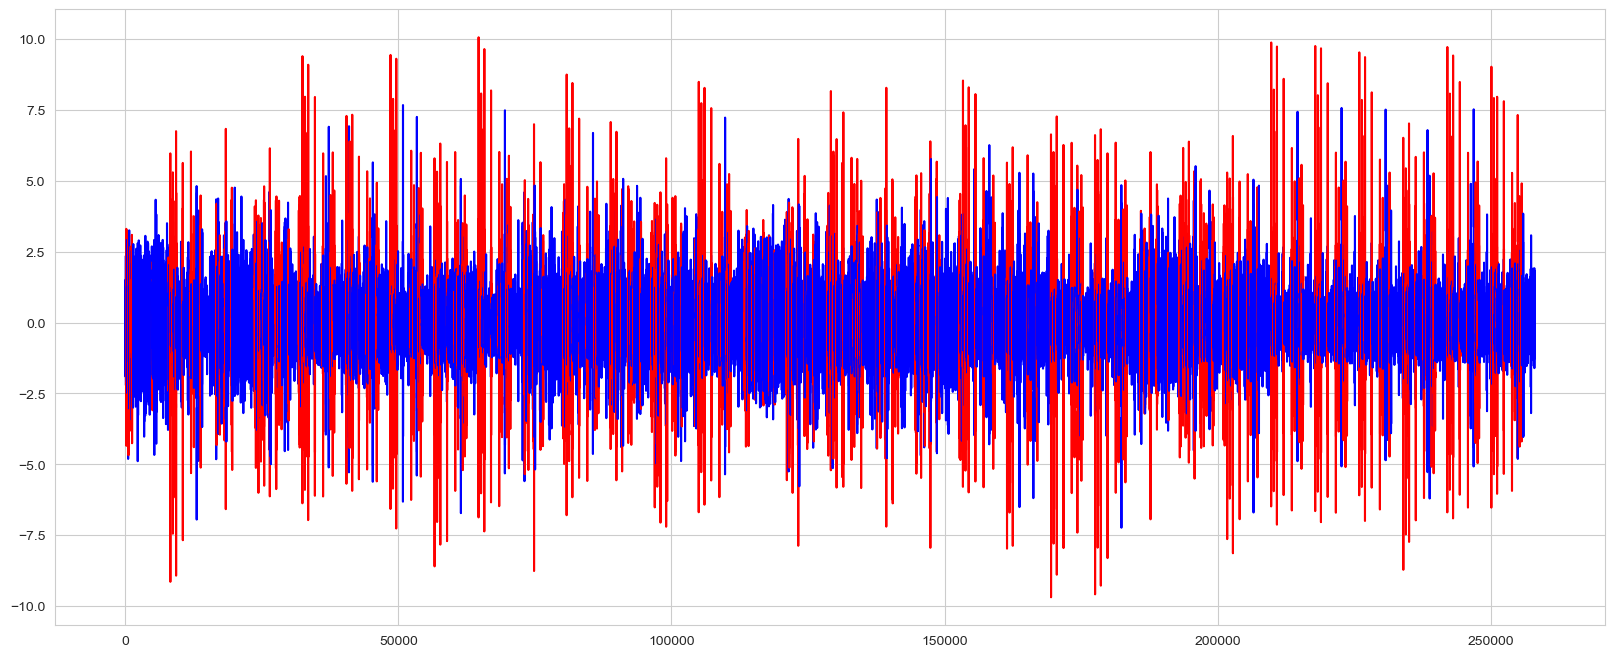

In [9]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):
    plt.rcParams["figure.figsize"] = (20,8)

    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [10]:
plt.rcdefaults()


In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from sklearn.metrics import confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [17]:
#Reading dataset
data = pd.read_csv("emotions.csv")
len(data)

2132

In [61]:
data.head
# data.shape

<bound method NDFrame.head of       # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  \
0          4.620      30.3    -356.0     15.60      26.3       1.070   
1         28.800      33.1      32.0     25.80      22.8       6.550   
2          8.900      29.4    -416.0     16.70      23.7      79.900   
3         14.900      31.6    -143.0     19.80      24.3      -0.584   
4         28.300      31.3      45.2     27.30      24.5      34.800   
...          ...       ...       ...       ...       ...         ...   
2127      32.400      32.2      32.2     30.80      23.4       1.640   
2128      16.300      31.3    -284.0     14.30      23.9       4.200   
2129      -0.547      28.3    -259.0     15.80      26.7       9.080   
2130      16.800      19.9    -288.0      8.34      26.0       2.460   
2131      27.000      32.0      31.8     25.00      28.9       4.990   

      mean_d_1_a  mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  \
0          0.411     -15.700     

In [19]:
#Seprarting Positive,Neagtive and Neutral dataframes for plortting
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

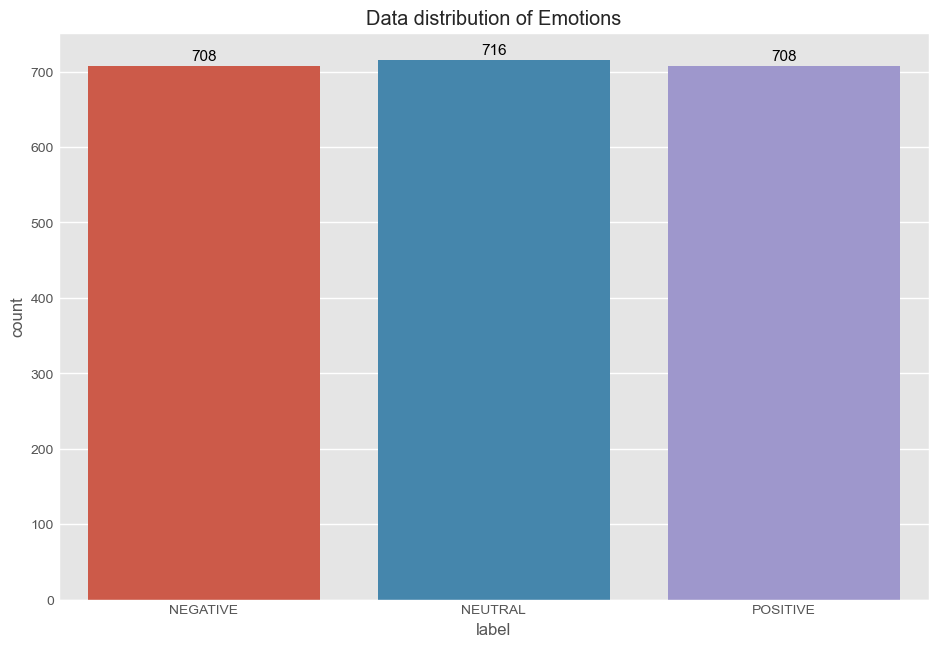

In [27]:
plt.figure(figsize=(10,7))
plt.title("Data distribution of Emotions")
plt.style.use('ggplot')  # Using ggplot style
ax = sns.countplot(x='label', data=data)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 7),
                textcoords='offset points')

plt.show()

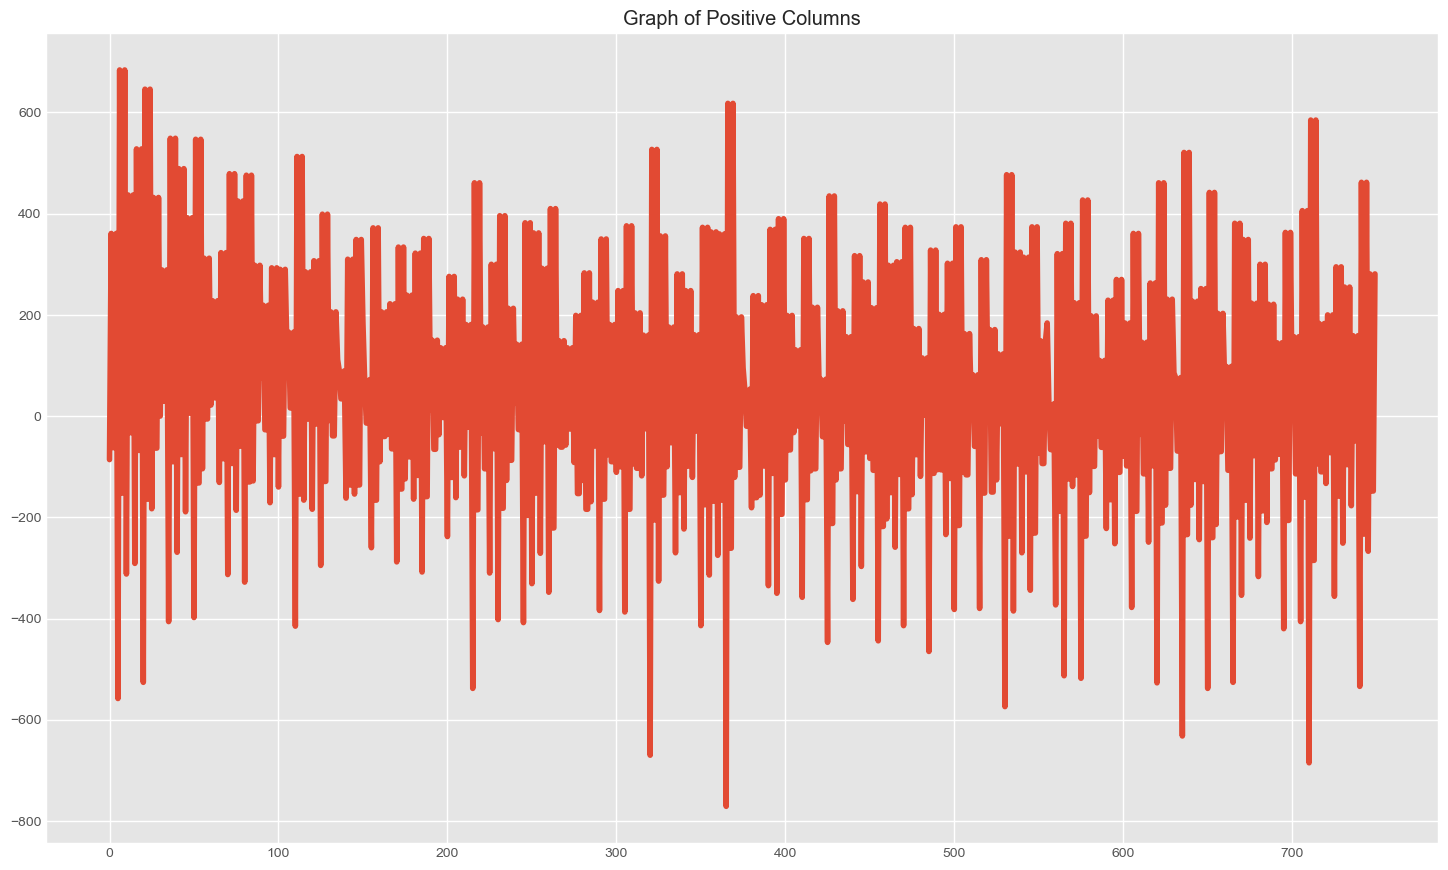

In [28]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()

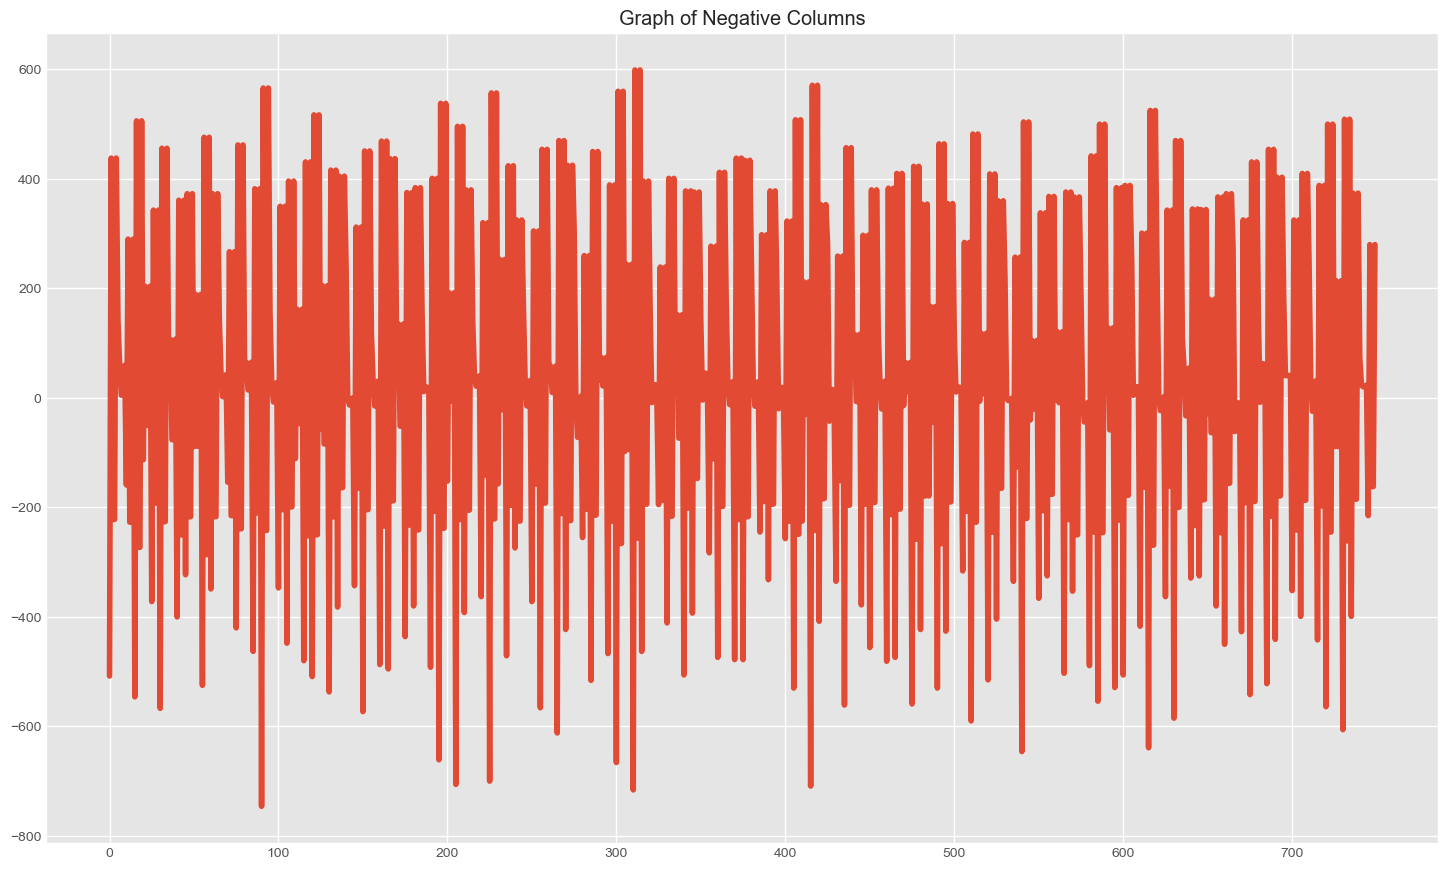

In [29]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()

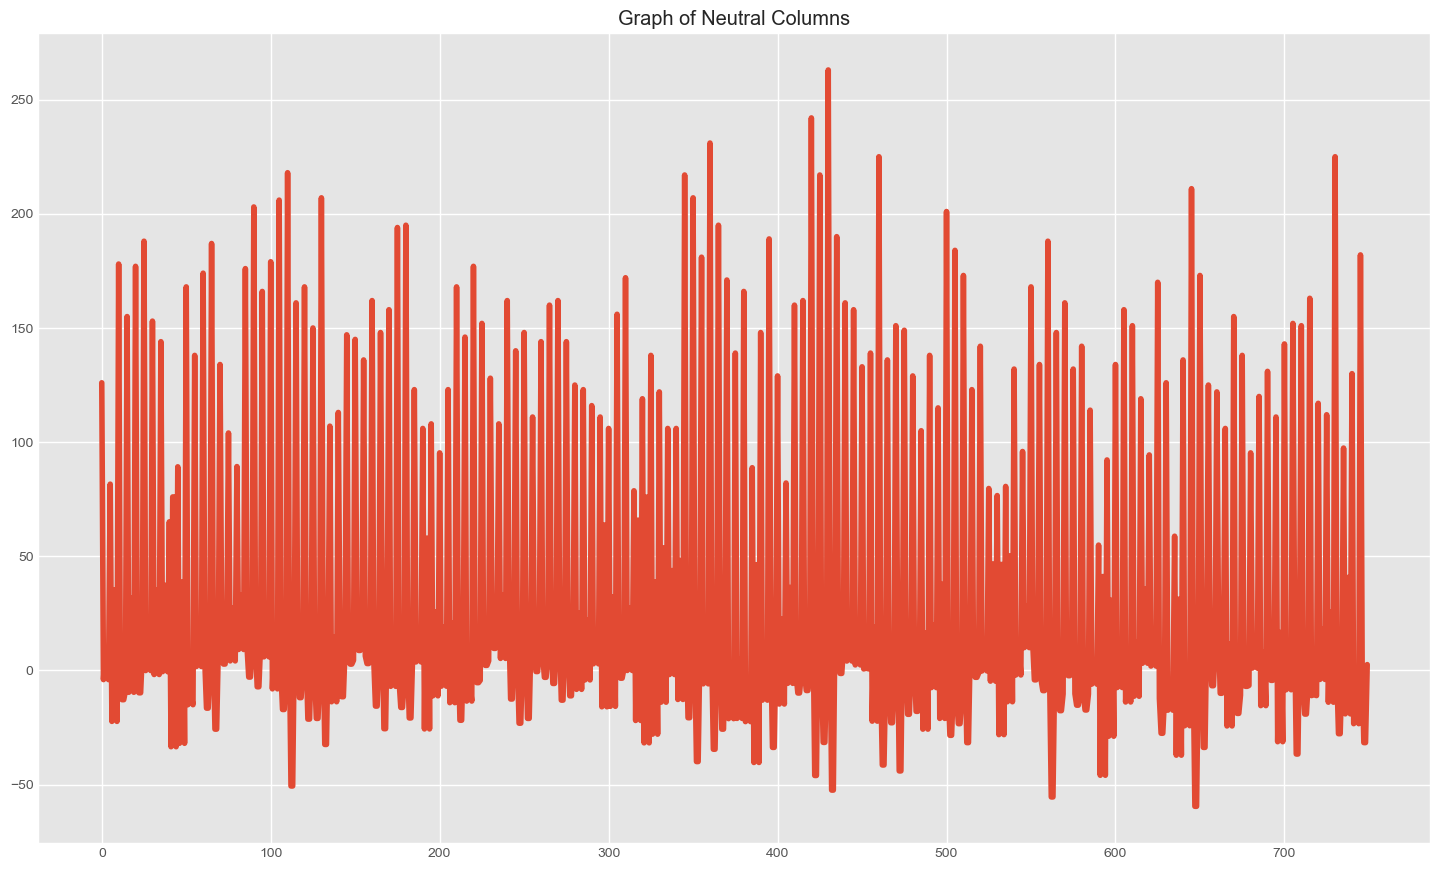

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()

In [31]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

In [32]:
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [62]:
import tensorflow as tf

def create_model():
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    expand_dims = tf.keras.layers.Reshape((x_train.shape[1], 1))(inputs)

    # 添加卷积层
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=7, activation='relu')(expand_dims)
    batch_norm1 = tf.keras.layers.BatchNormalization()(conv1)
    maxpool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_norm1)

    conv2 = tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu')(maxpool1)
    batch_norm2 = tf.keras.layers.BatchNormalization()(conv2)
    maxpool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_norm2)

    # 使用双向GRU层
    bi_gru = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True)
    )(maxpool2)
    batch_norm3 = tf.keras.layers.BatchNormalization()(bi_gru)

    flatten = tf.keras.layers.Flatten()(batch_norm3)

    # 添加更多的全连接层
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    batch_norm4 = tf.keras.layers.BatchNormalization()(dropout1)

    dense2 = tf.keras.layers.Dense(64, activation='relu')(batch_norm4)
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    batch_norm5 = tf.keras.layers.BatchNormalization()(dropout2)

    dense3 = tf.keras.layers.Dense(32, activation='relu')(batch_norm5)
    dropout3 = tf.keras.layers.Dropout(0.5)(dense3)
    batch_norm6 = tf.keras.layers.BatchNormalization()(dropout3)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(batch_norm6)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


In [63]:
#cretaing model
lstmmodel = create_model()
#Compiling model
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2548)]            0         
                                                                 
 reshape_1 (Reshape)         (None, 2548, 1)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2542, 64)          512       
                                                                 
 batch_normalization_7 (Batc  (None, 2542, 64)         256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1271, 64)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1267, 32)          1027

In [64]:
history = lstmmodel.fit(x_train, y_train, epochs = 30, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/30
48/48 [==============================] - 26s 511ms/step - loss: 1.0299 - accuracy: 0.5495 - val_loss: 0.9955 - val_accuracy: 0.3684
Epoch 2/30
48/48 [==============================] - 20s 418ms/step - loss: 0.5946 - accuracy: 0.7581 - val_loss: 1.2803 - val_accuracy: 0.2982
Epoch 3/30
48/48 [==============================] - 19s 389ms/step - loss: 0.4797 - accuracy: 0.8077 - val_loss: 1.4821 - val_accuracy: 0.2982
Epoch 4/30
48/48 [==============================] - 21s 434ms/step - loss: 0.4066 - accuracy: 0.8572 - val_loss: 1.4230 - val_accuracy: 0.3041
Epoch 5/30
48/48 [==============================] - 20s 426ms/step - loss: 0.3304 - accuracy: 0.8794 - val_loss: 1.7558 - val_accuracy: 0.2982
Epoch 6/30
48/48 [==============================] - 20s 423ms/step - loss: 0.2910 - accuracy: 0.9055 - val_loss: 1.6455 - val_accuracy: 0.3333
Epoch 7/30
48/48 [==============================] - 24s 496ms/step - loss: 0.2983 - accuracy: 0.9035 - val_loss: 0.6082 - val_accuracy: 0.7135

In [65]:
#Loss and Accuracy of model on Testiong Dataset
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 3.964965045452118 
Accuracy on Training: 98.59485030174255


In [66]:
#predicting model on test set for plotting Confusion Matrix
pred  = lstmmodel.predict(x_test)

14/14 [==============================] - 1s 79ms/step


In [67]:
#Creation of Function of Confusion Matrix
def my_plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
pred1 = np.argmax(pred,axis=1)
y_test1 =   np.argmax(y_test,axis=1)

In [69]:
print("Predicted:  ",pred1[:10])
print("Actual: ",y_test1[:10])

Predicted:   [1 1 1 1 1 1 2 1 2 1]
Actual:  [1 1 1 2 1 1 2 1 2 1]


Confusion matrix, without normalization
[[153   0   0]
 [  0 137   5]
 [  0   1 131]]


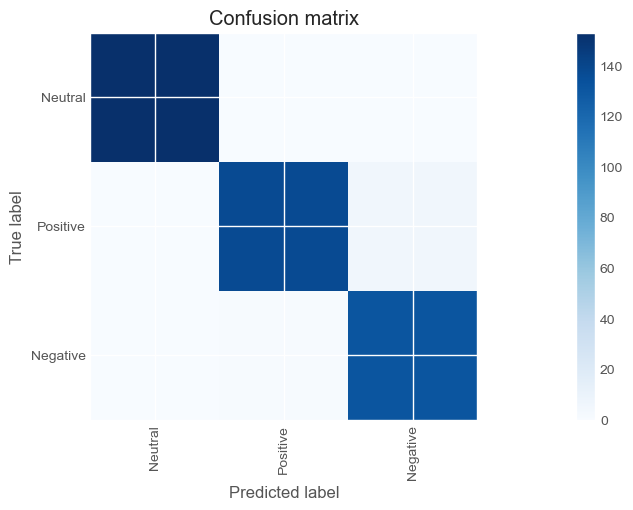

In [70]:
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
my_plot_confusion_matrix(cm,["Neutral","Positive","Negative"])

In [48]:
#Training our dataset on different Classifiers to check the results and creating their classification reports
names1 = ["Neutral","Positive","Negative"]

#NAves Bayes Clssifier
Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)

### Support Vector Machine
Classifier_svm = svm.SVC(kernel='linear').fit(x_train, np.argmax(y_train,axis=1))
pred_svm = Classifier_svm.predict(x_test)
print ('\n*\t\tClassification Report SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_svm))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_svm)

### Logistic Regression
Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
print ('\n*\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)

### Decision Tree Regressor
Classifier_dt = tree.DecisionTreeClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_dt = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Deccsion Tree:\n', classification_report(np.argmax(y_test,axis=1), pred_dt))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_dt)

### Random Forest
Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)

### K-Nearest Neighbors
Classifier_knn = KNeighborsClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_knn = Classifier_knn.predict(x_test)
print ('\n*\t\tClassification Report KNN:\n', classification_report(np.argmax(y_test,axis=1), pred_knn))

### Multilayer Perceptron
Classifier_mlp = MLPClassifier(max_iter=1000).fit(x_train, np.argmax(y_train,axis=1))
pred_mlp = Classifier_mlp.predict(x_test)
print ('\n*\t\tClassification Report MLP:\n', classification_report(np.argmax(y_test,axis=1), pred_mlp))

### Gradient Boosting
Classifier_gb = GradientBoostingClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_gb = Classifier_gb.predict(x_test)
print ('\n*\t\tClassification Report Gradient Boosting:\n', classification_report(np.argmax(y_test,axis=1), pred_gb))

### AdaBoost
Classifier_ab = AdaBoostClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_ab = Classifier_ab.predict(x_test)
print ('\n*\t\tClassification Report AdaBoost:\n', classification_report(np.argmax(y_test,axis=1), pred_ab))

### Quadratic Discriminant Analysis
Classifier_qda = QuadraticDiscriminantAnalysis().fit(x_train, np.argmax(y_train,axis=1))
pred_qda = Classifier_qda.predict(x_test)
print ('\n*\t\tClassification Report QDA:\n', classification_report(np.argmax(y_test,axis=1), pred_qda))

### Nearest Centroid Classifier
Classifier_nc = NearestCentroid().fit(x_train, np.argmax(y_train,axis=1))
pred_nc = Classifier_nc.predict(x_test)
print ('\n*\t\tClassification Report Nearest Centroid:\n', classification_report(np.argmax(y_test,axis=1), pred_nc))

### Linear Support Vector Classification
Classifier_lsvc = LinearSVC().fit(x_train, np.argmax(y_train,axis=1))
pred_lsvc = Classifier_lsvc.predict(x_test)
print ('\n*\t\tClassification Report Linear SVC:\n', classification_report(np.argmax(y_test,axis=1), pred_lsvc))

### Kernelized Support Vector Machine
Classifier_ksvm = SVC(kernel='rbf').fit(x_train, np.argmax(y_train,axis=1))
pred_ksvm = Classifier_ksvm.predict(x_test)
print ('\n*\t\tClassification Report Kernelized SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_ksvm))

### Perceptron
Classifier_perc = Perceptron().fit(x_train, np.argmax(y_train,axis=1))
pred_perc = Classifier_perc.predict(x_test)
print ('\n*\t\tClassification Report Perceptron:\n', classification_report(np.argmax(y_test,axis=1), pred_perc))

### Linear Discriminant Analysis
Classifier_lda = LinearDiscriminantAnalysis().fit(x_train, np.argmax(y_train,axis=1))
pred_lda = Classifier_lda.predict(x_test)
print ('\n*\t\tClassification Report LDA:\n', classification_report(np.argmax(y_test,axis=1), pred_lda))

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
# classifiers = [GaussianNB(),svm.SVC(kernel='linear'),
#                linear_model.LogisticRegression(solver = 'liblinear', C = 75),
#                RandomForestClassifier(n_estimators = 50, random_state = 0)]
# for cls in classifiers:
#     cls.fit(x_train,np.argmax(y_train,axis=1))
#
# colors = [ 'YlOrBr', 'GnBu', 'Pastel2', 'PuRd']
# for cls, ax,c in zip(classifiers, axes.flatten(),colors):
#     plot_confusion_matrix(cls,
#                           x_test,
#                           np.argmax(y_test,axis=1),
#                           ax=ax,
#                           cmap=c,
#                          display_labels= names1)
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()
# plt.show()
# 将所有分类器添加到一个列表中
classifiers = [
    Classifier_gnb, Classifier_svm, Classifier_LR, Classifier_dt,
    Classifier_forest, Classifier_knn, Classifier_mlp, Classifier_gb,
    Classifier_ab, Classifier_qda, Classifier_nc, Classifier_lsvc,
    Classifier_ksvm, Classifier_perc, Classifier_lda
]

# 为每个分类器的名称创建一个列表
classifier_names = [
    "GaussianNB", "SVM", "Logistic Regression", "Decision Tree",
    "Random Forest", "KNN", "MLP", "Gradient Boosting",
    "AdaBoost", "QDA", "Nearest Centroid", "Linear SVC",
    "Kernelized SVM", "Perceptron", "LDA"
]


*		Classification Report GNB:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       153
           1       0.46      0.30      0.36       142
           2       0.81      0.66      0.73       132

    accuracy                           0.65       427
   macro avg       0.64      0.64      0.62       427
weighted avg       0.64      0.65      0.62       427


*		Classification Report SVM:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       153
           1       0.98      0.89      0.94       142
           2       0.94      0.99      0.97       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427


*		Classification Report LR:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.98      0.94 

/Users/haydengu/anaconda3/envs/rl-summer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haydengu/anaconda3/envs/rl-summer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haydengu/anaconda3/envs/rl-summer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m


*		Classification Report AdaBoost:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.50      1.00      0.66       142
           2       0.00      0.00      0.00       132

    accuracy                           0.66       427
   macro avg       0.50      0.64      0.54       427
weighted avg       0.52      0.66      0.56       427



/Users/haydengu/anaconda3/envs/rl-summer/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



*		Classification Report QDA:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       153
           1       0.62      0.35      0.45       142
           2       0.57      0.80      0.66       132

    accuracy                           0.63       427
   macro avg       0.63      0.63      0.61       427
weighted avg       0.63      0.63      0.61       427


*		Classification Report Nearest Centroid:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       153
           1       0.69      0.59      0.64       142
           2       0.83      0.72      0.77       132

    accuracy                           0.78       427
   macro avg       0.77      0.77      0.77       427
weighted avg       0.77      0.78      0.77       427



/Users/haydengu/anaconda3/envs/rl-summer/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



*		Classification Report Linear SVC:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.94      0.96       142
           2       0.96      0.99      0.98       132

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427


*		Classification Report Kernelized SVM:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       153
           1       0.95      0.87      0.91       142
           2       0.92      0.99      0.95       132

    accuracy                           0.94       427
   macro avg       0.94      0.94      0.94       427
weighted avg       0.94      0.94      0.94       427


*		Classification Report Perceptron:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       153
        

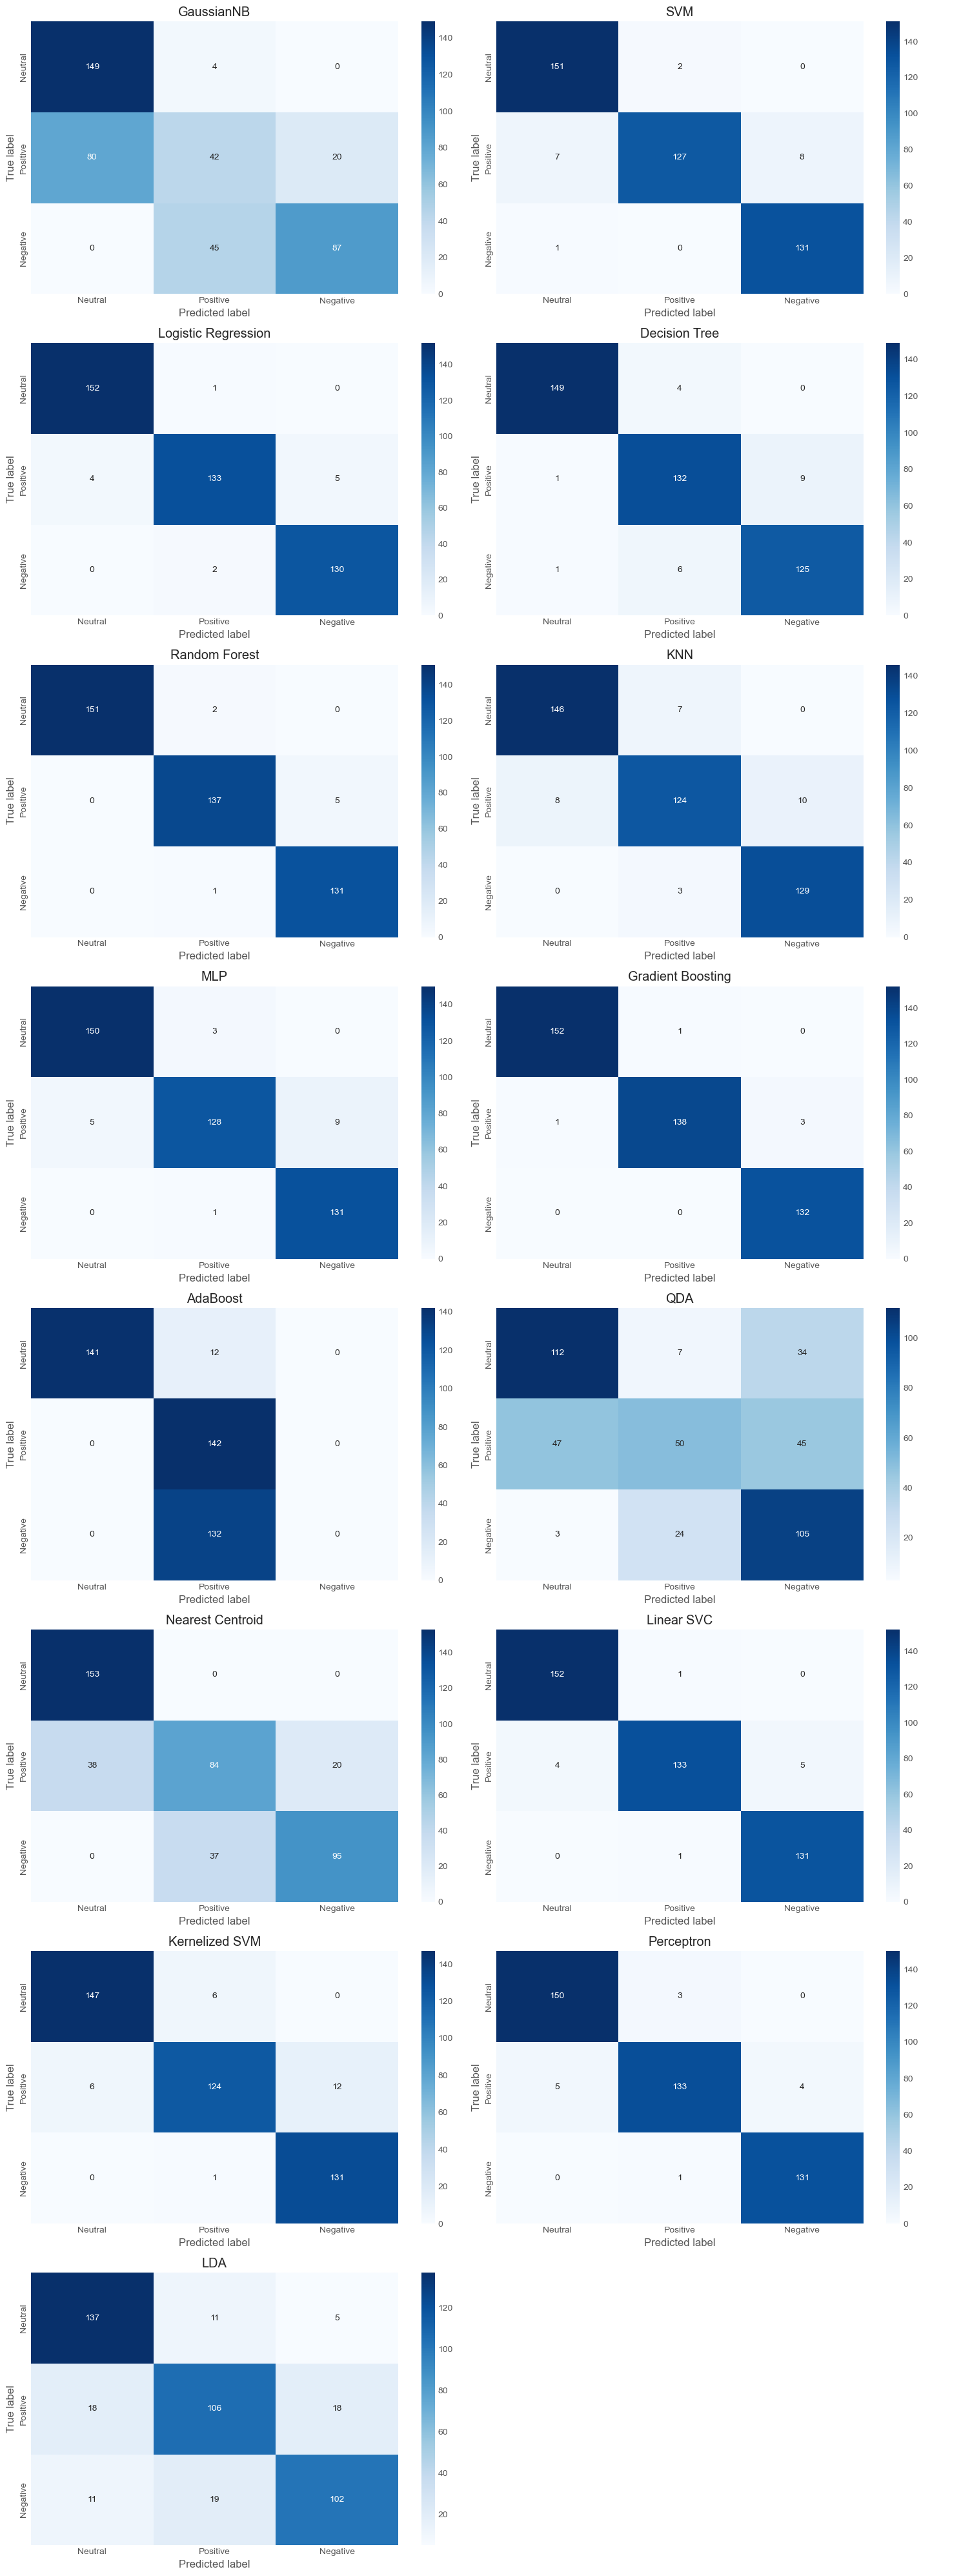

In [55]:
def plot_confusion_matrix(y_true, y_pred, classes, ax=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        ax = plt.gca()

    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=classes, yticklabels=classes)

    ax.set(title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

# 计算需要的子图行数
num_classifiers = len(classifiers)
num_cols = 2  # 设置每行显示2个子图
num_rows = num_classifiers // num_cols + (num_classifiers % num_cols > 0)

# 设置图形大小
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

# 如果axes是一维数组，将其转换为二维数组，以便我们可以统一处理
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# 遍历分类器和它们的名称，绘制混淆矩阵
for cls, name, ax in zip(classifiers, classifier_names, axes.flatten()):
    y_pred = cls.predict(x_test)
    plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred, names1, ax=ax, cmap='Blues')
    ax.title.set_text(name)

# 如果子图数量不是偶数，隐藏最后一个子图
if num_classifiers % num_cols != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [72]:
print('\n*\t\tClassification Report OF Brain Waves GRU-CNN:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

14/14 [==============================] - 1s 78ms/step

*		Classification Report OF Brain Waves GRU-CNN:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       0.99      0.96      0.98       142
           2       0.96      0.99      0.98       132

    accuracy                           0.99       427
   macro avg       0.99      0.99      0.99       427
weighted avg       0.99      0.99      0.99       427



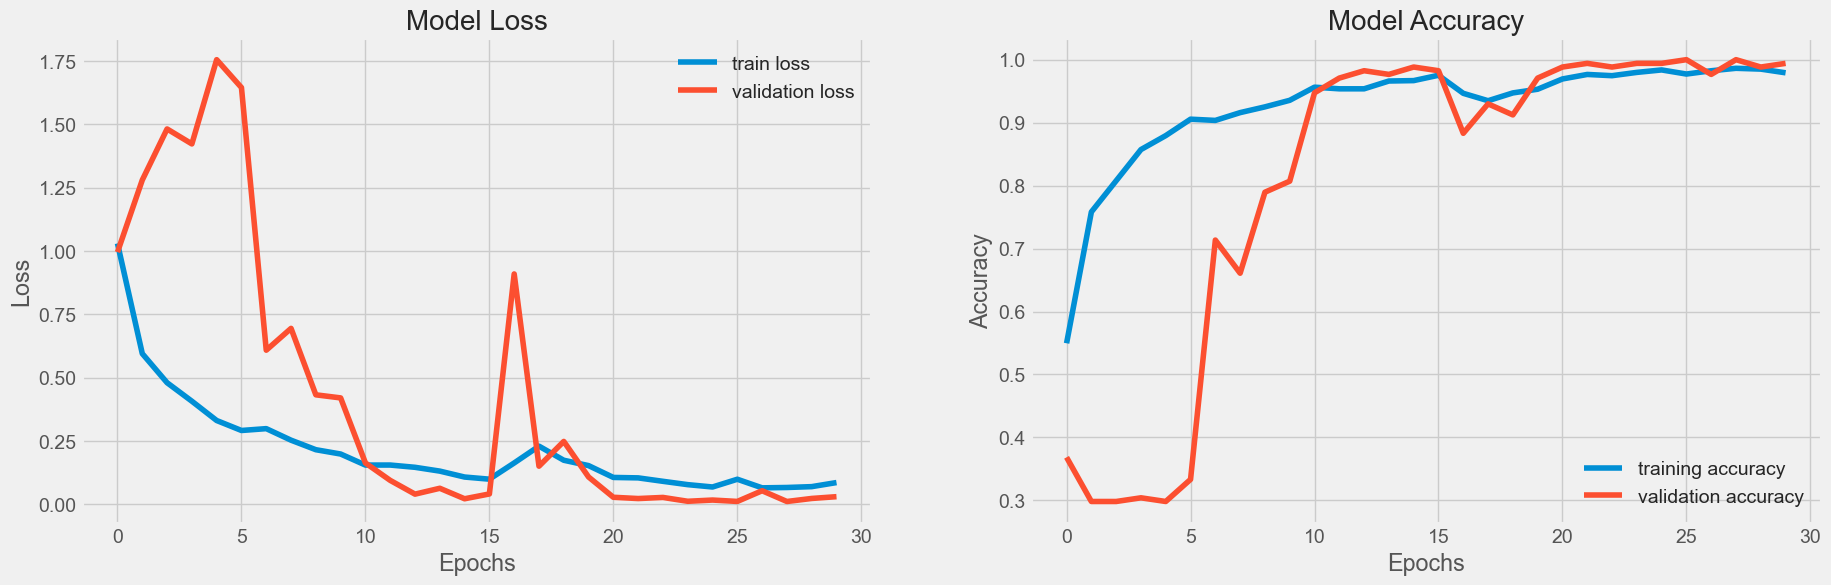

In [73]:
#Plotting Graph of Lstm model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

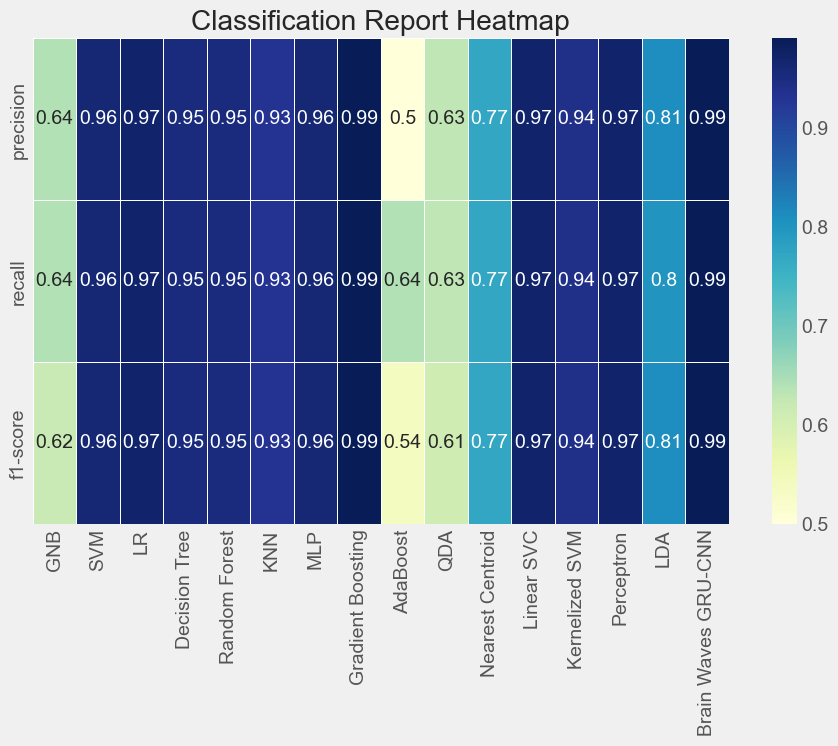

In [75]:
# Heat Map
models = ["GNB", "SVM", "LR", "Decision Tree", "Random Forest", "KNN", "MLP", "Gradient Boosting", "AdaBoost", "QDA", "Nearest Centroid", "Linear SVC", "Kernelized SVM", "Perceptron", "LDA", "Brain Waves GRU-CNN"]
metrics = ["precision", "recall", "f1-score"]
data = {
    "GNB": [0.64, 0.64, 0.62],
    "SVM": [0.96, 0.96, 0.96],
    "LR": [0.97, 0.97, 0.97],
    "Decision Tree": [0.95, 0.95, 0.95],
    "Random Forest": [0.95, 0.95, 0.95],
    "KNN": [0.93, 0.93, 0.93],
    "MLP": [0.96, 0.96, 0.96],
    "Gradient Boosting": [0.99, 0.99, 0.99],
    "AdaBoost": [0.50, 0.64, 0.54],
    "QDA": [0.63, 0.63, 0.61],
    "Nearest Centroid": [0.77, 0.77, 0.77],
    "Linear SVC": [0.97, 0.97, 0.97],
    "Kernelized SVM": [0.94, 0.94, 0.94],
    "Perceptron": [0.97, 0.97, 0.97],
    "LDA": [0.81, 0.80, 0.81],
    "Brain Waves GRU-CNN": [0.99, 0.99, 0.99]  # 添加新模型的数据
}


df = pd.DataFrame(data, index=metrics)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Classification Report Heatmap")
plt.show()

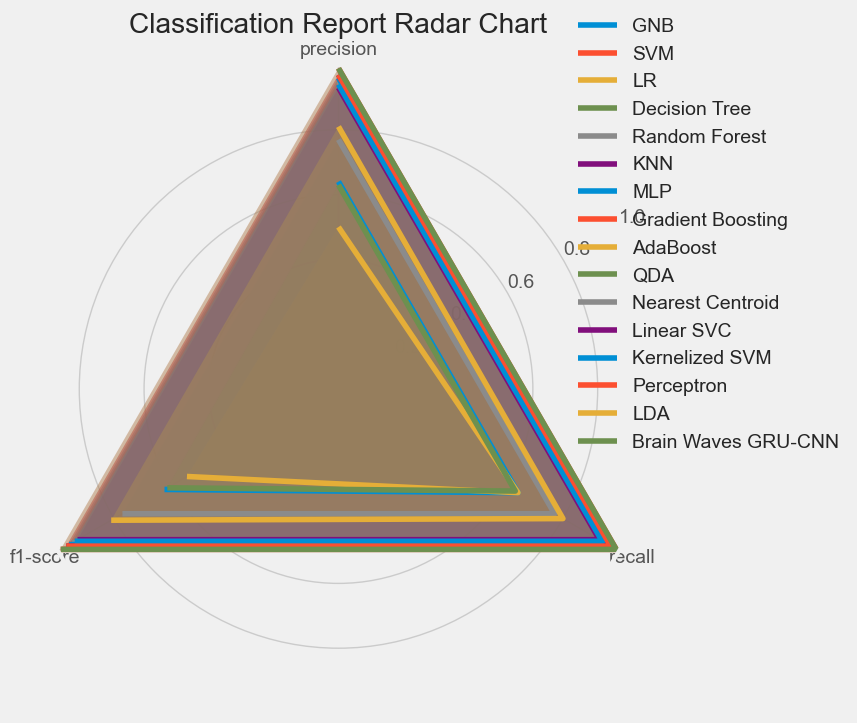

In [76]:
import numpy as np

# 为雷达图准备数据
labels = np.array(metrics)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 绘制雷达图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model, values in data.items():
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.title("Classification Report Radar Chart")
plt.show()


In [77]:
from mpl_toolkits.mplot3d import Axes3D

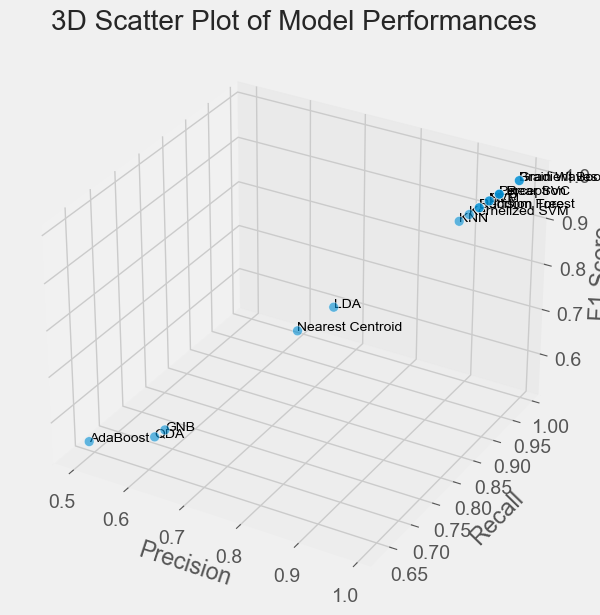

In [78]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(data).T.reset_index()
df.columns = ['Model', 'Precision', 'Recall', 'F1']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(df['Precision'], df['Recall'], df['F1'], s=50, alpha=0.6, edgecolors='w')

# Adding labels
for i, txt in enumerate(df['Model']):
    ax.text(df['Precision'][i], df['Recall'][i], df['F1'][i], txt, size=10, zorder=1, color='k')

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_zlabel('F1 Score')
ax.set_title('3D Scatter Plot of Model Performances')

plt.show()

In [79]:
%pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [80]:
import squarify

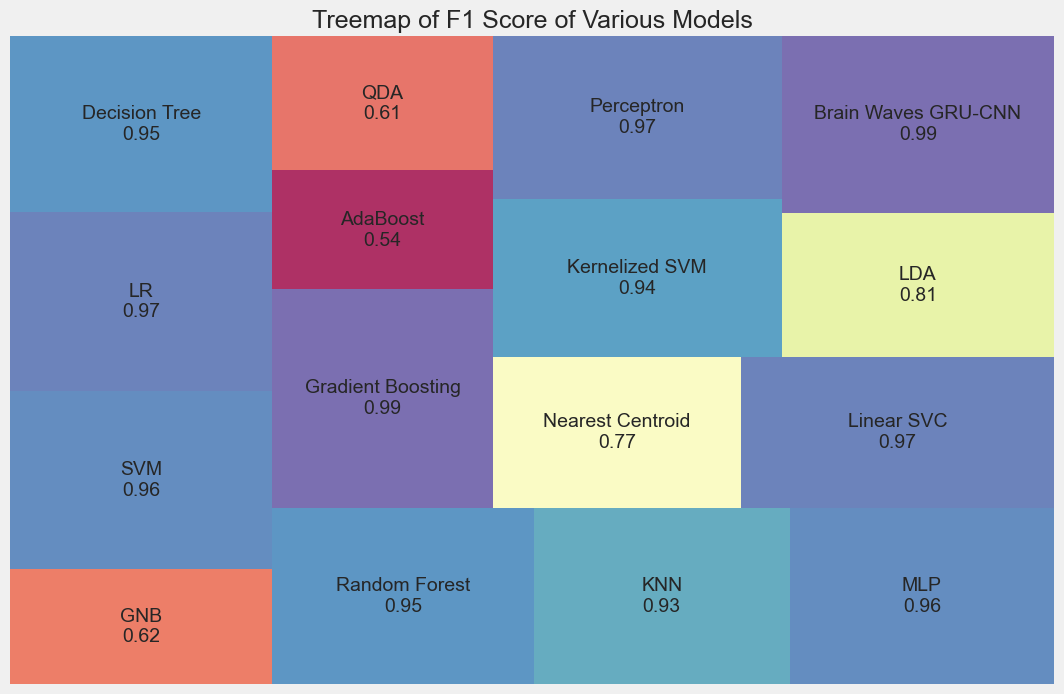

In [81]:
# Extracting F1 scores as the size of the squares
sizes = [val[2] for val in data.values()]

# Creating labels for the squares
labels = [f"{key}\n{val[2]:.2f}" for key, val in data.items()]

# Creating a color map
cmap = plt.cm.Spectral
mini=min(sizes)
maxi=max(sizes)
norm = plt.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in sizes]

# Creating the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=.8, color=colors)
plt.title("Treemap of F1 Score of Various Models", fontsize=18)
plt.axis('off')
plt.show()

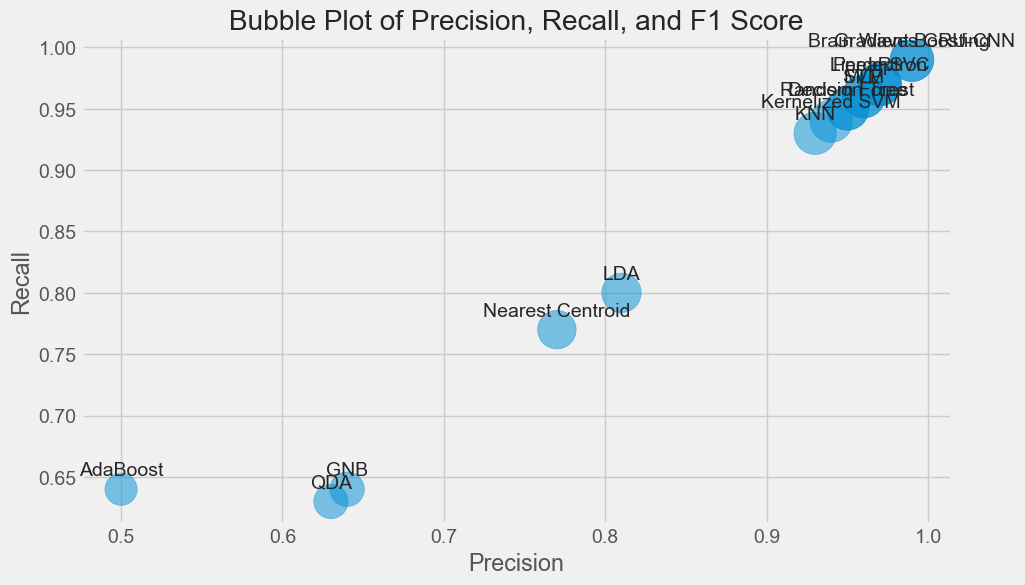

In [82]:
# Extracting precision, recall, and F1 score
precision = [val[0] for val in data.values()]
recall = [val[1] for val in data.values()]
f1 = [val[2] for val in data.values()]

# Creating labels for the bubbles
labels = [key for key in data.keys()]

# Creating the bubble plot
plt.figure(figsize=(10, 6))
plt.scatter(precision, recall, s=[score*1000 for score in f1], alpha=0.5)

# Adding labels to the bubbles
for i, txt in enumerate(labels):
    plt.annotate(txt, (precision[i], recall[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Bubble Plot of Precision, Recall, and F1 Score")
plt.grid(True)
plt.show()